In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from xgboost import XGBRegressor

C:\Users\USER\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df = pd.read_csv(r"d:\Users\USER\Desktop\Property\train.csv")
df=pd.DataFrame(df)
df.shape

(1460, 81)

In [4]:
def nllval(data):
    cname=(data.isnull().sum().sort_values(ascending = False))/len(df)*100
    print(cname.head(20))

In [5]:
nllval(df)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64


<AxesSubplot:>

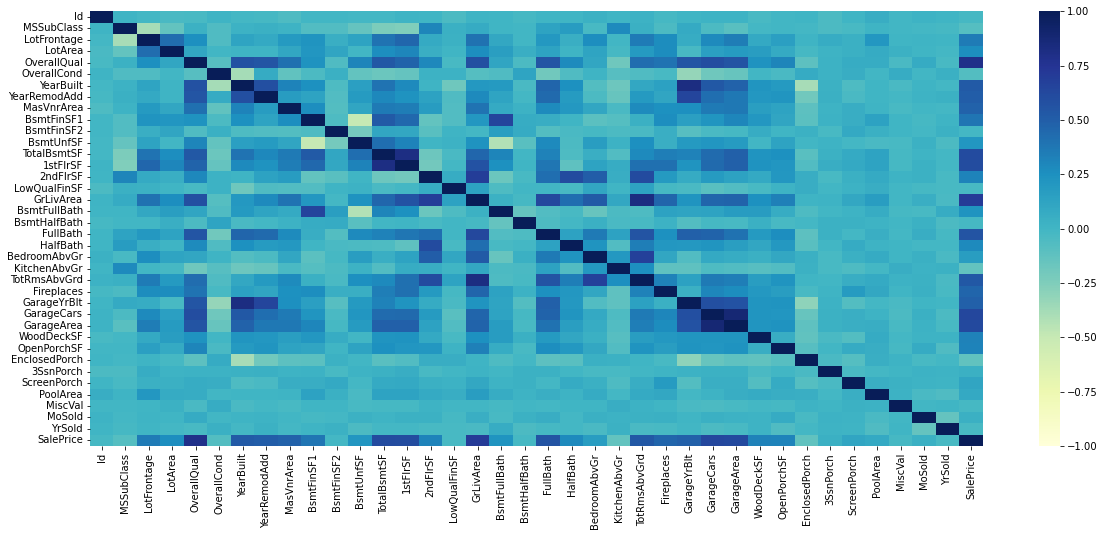

In [6]:
plt.figure(figsize=(20,8))
sns.heatmap((df.corr()),cmap="YlGnBu",vmin=-1,vmax=1,)


In [7]:
def similar_clounmn(df,thresold):
    cormat = df.corr()
    setcol = set()
    for i in range(len(cormat)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > thresold:
                setcol.add(cormat.columns[i])
    return setcol

In [8]:
reove=similar_clounmn(df,0.7)
reove=set(reove)

reove

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'SalePrice', 'TotRmsAbvGrd'}

In [9]:
x=df.drop('SalePrice',axis=1)
y=df['SalePrice']


In [10]:
reove=similar_clounmn(x,0.7)
reove=set(reove)
x.drop(reove,axis=1,inplace=True)
x.shape

(1460, 76)

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split( x,y,test_size=0.3,random_state=2)
x.shape,x_train.shape,x_test.shape

((1460, 76), (1022, 76), (438, 76))

In [28]:
def objectcolumns(df,graph):
    deke=set()
    for i in df:
        if df[i].dtype == 'O':
            if len(df[i].unique()) < 10:
                deke.add(i)
                if graph == 1:
                    df[i].value_counts().plot(kind='bar')
                    plt.title(i)
                    plt.ylabel('Count')
                    plt.xlabel(i)
                    plt.show()
    return deke
        

In [13]:
objects=objectcolumns(x_train,0)
objects
x_train[objects].isnull().sum().sort_values(ascending=False).head(20)

C:\Users\USER\AppData\Local\Temp\ipykernel_11872\2406067635.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train[objects].isnull().sum().sort_values(ascending=False).head(20)


PoolQC          1020
MiscFeature      979
Alley            954
Fence            821
FireplaceQu      497
GarageQual        58
GarageFinish      58
GarageCond        58
GarageType        58
BsmtExposure      27
BsmtFinType1      26
BsmtCond          26
BsmtQual          26
BsmtFinType2      26
MasVnrType         6
Electrical         1
ExterQual          0
RoofStyle          0
LotShape           0
PavedDrive         0
dtype: int64

Handling missing Values

In [14]:
x_train['MiscFeature'].fillna('empty',inplace=True)   # Miscellaneous feature are not Present

x_train['GarageType'].fillna('empty',inplace=True)   # Since the count of Emmpty values are same Cant be Coincidence
x_train['GarageCond'].fillna('empty',inplace=True)
x_train['GarageQual'].fillna('empty',inplace=True)
x_train['GarageFinish'].fillna('empty',inplace=True)

x_train['Fence'].fillna('empty',inplace=True)     # assuming NO Fence 
x_train['MiscFeature'].fillna('empty',inplace=True)   # Miscellaneous feature are not Present

x_train['BsmtCond'].fillna('empty',inplace=True)   # Since the count of Emmpty values are equal
x_train['BsmtExposure'].fillna('empty',inplace=True)   
x_train['BsmtFinType1'].fillna('empty',inplace=True)   
x_train['BsmtFinType2'].fillna('empty',inplace=True)   
x_train['BsmtQual'].fillna('empty',inplace=True)  

x_train['FireplaceQu'] = np.where(((pd.isnull(x_train['FireplaceQu'])) & (x_train['Fireplaces']==0)),'Empty',x_train['FireplaceQu'])    #  replacing Empty Where Fire Places equal t0 0 

x_train['MasVnrType'].fillna('empty',inplace=True)      # replacing with Empty Value

x_train['Electrical'].fillna(x_train['Electrical'].mode().values[0],inplace=True)     # filling with Mode Value since the House Cannot be with the Electrical System so assigning the Common type of Electrical System


x_train['PoolQC'] = np.where(((pd.isnull(x_train['PoolQC'])) & (x_train['PoolArea']==0)),'Empty',x_train['PoolQC'])  #  if the Pool Area is Zero then pool Quality will be empty


x_train['Alley'].fillna('empty',inplace=True)      # replacing with Empty Value since the % of missing Vlaues is High assuming it cannot be mistake so creating seperate Category



In [15]:
objects=objectcolumns(x_train,0)
objects
x_train[objects].isnull().sum().sort_values(ascending=False).head(20)

C:\Users\USER\AppData\Local\Temp\ipykernel_11872\2406067635.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train[objects].isnull().sum().sort_values(ascending=False).head(20)


MiscFeature      0
Heating          0
SaleCondition    0
Electrical       0
MasVnrType       0
BsmtCond         0
Alley            0
GarageCond       0
LotShape         0
RoofStyle        0
ExterQual        0
BsmtQual         0
PavedDrive       0
MSZoning         0
GarageQual       0
BsmtExposure     0
LandContour      0
Fence            0
Condition1       0
KitchenQual      0
dtype: int64

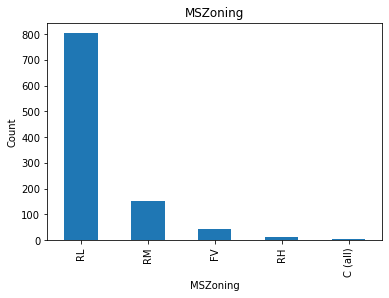

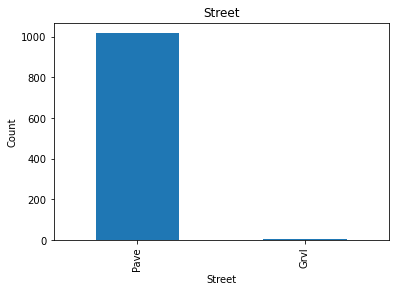

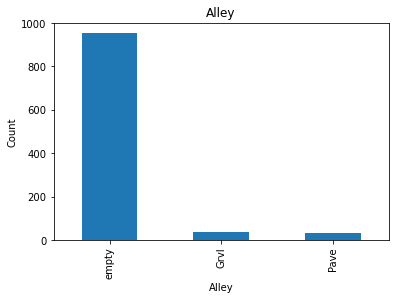

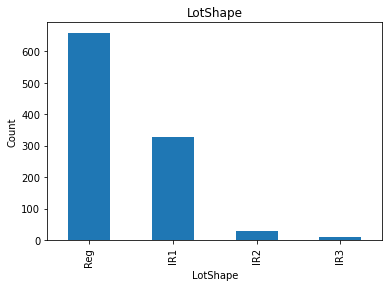

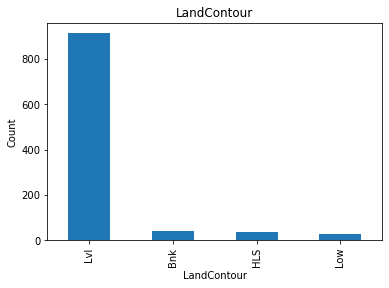

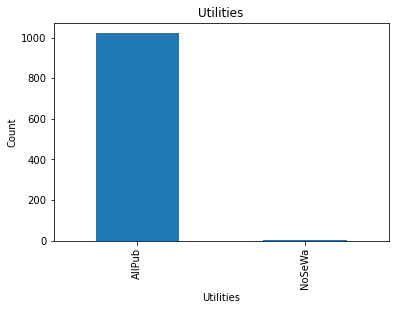

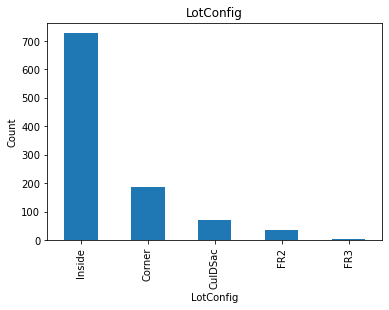

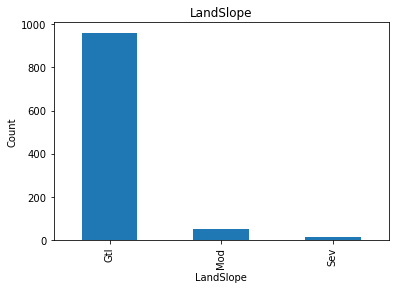

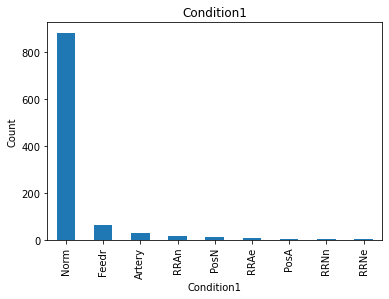

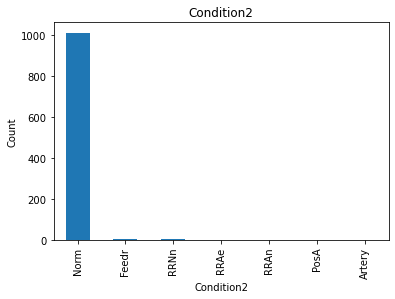

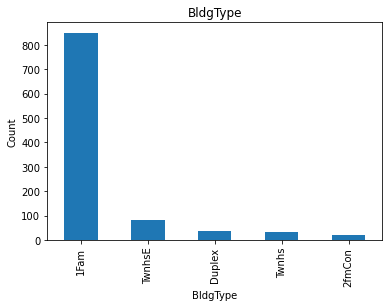

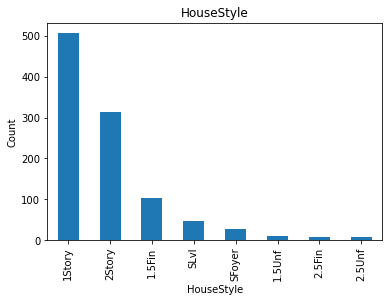

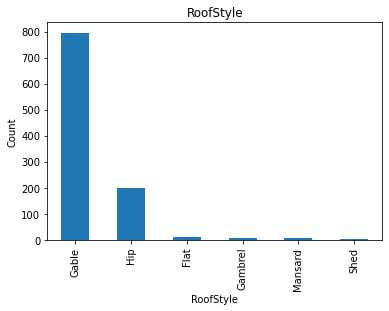

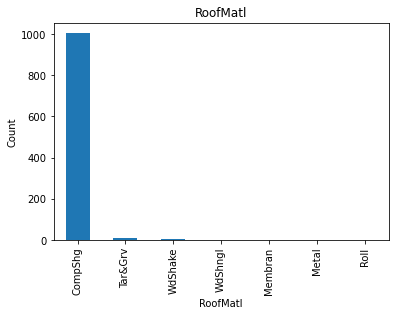

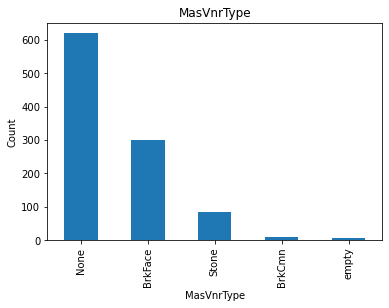

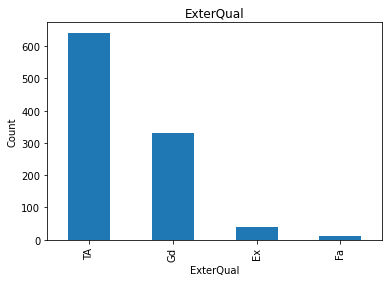

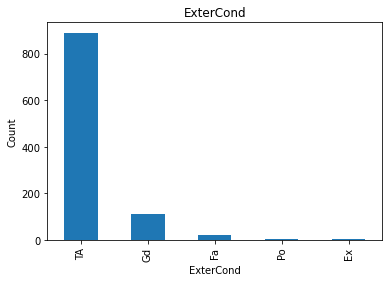

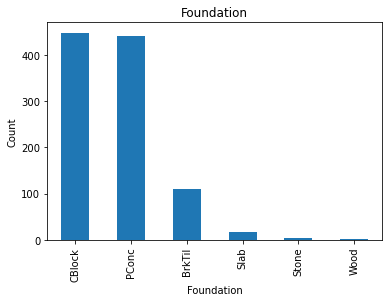

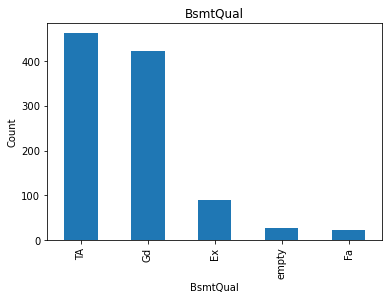

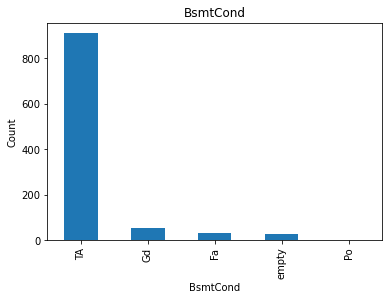

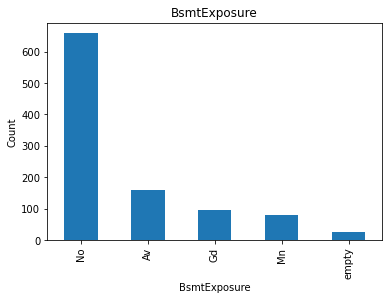

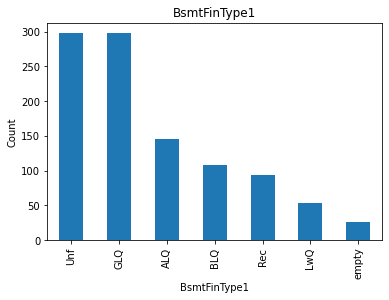

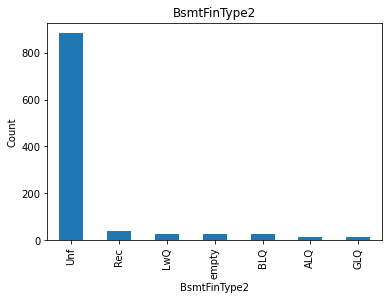

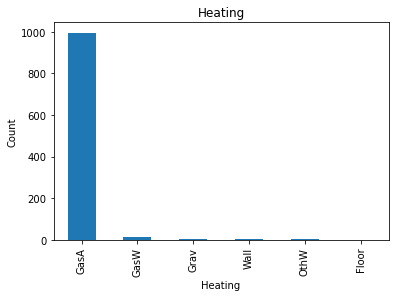

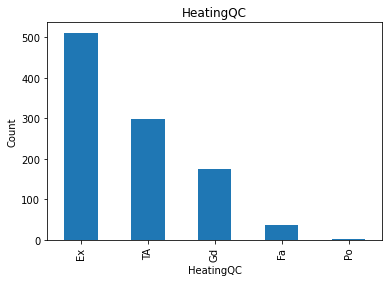

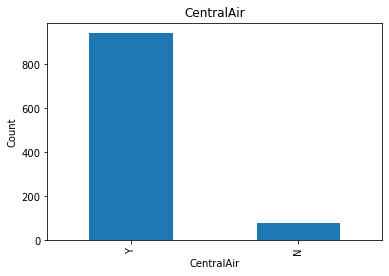

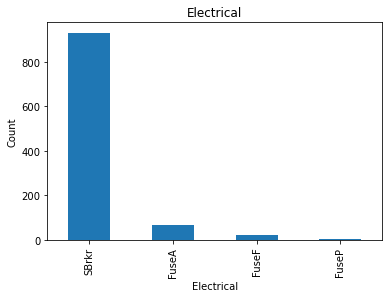

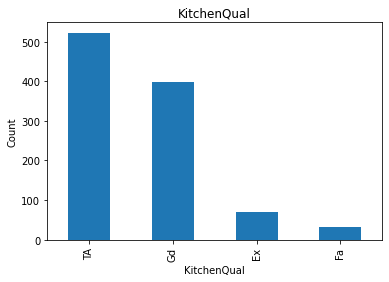

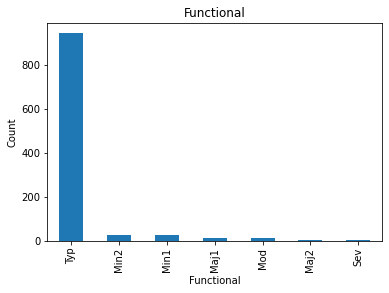

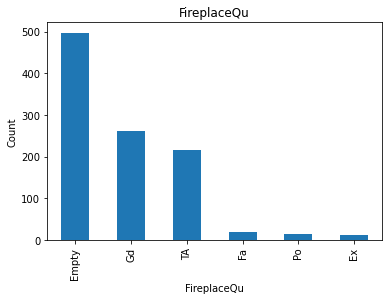

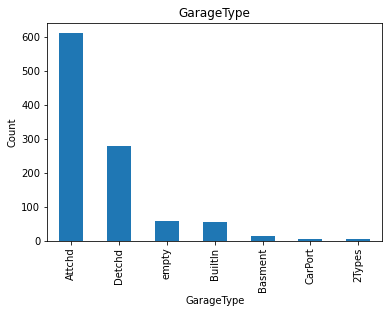

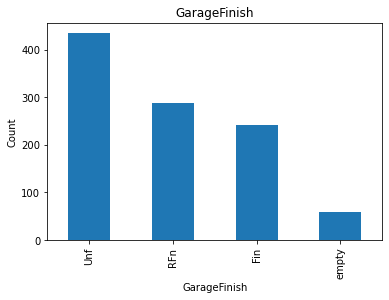

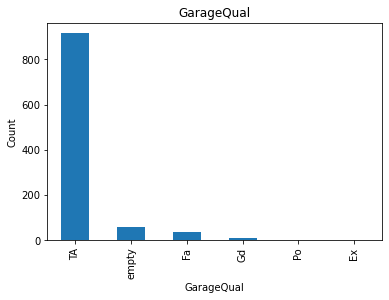

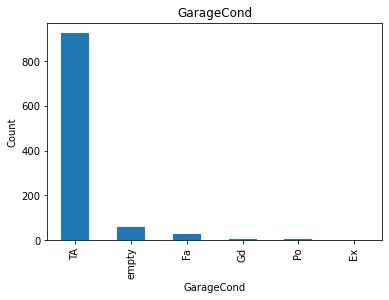

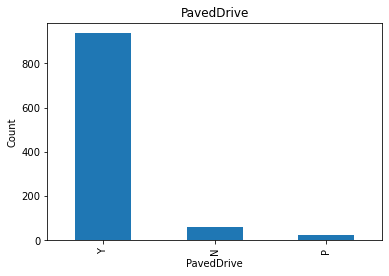

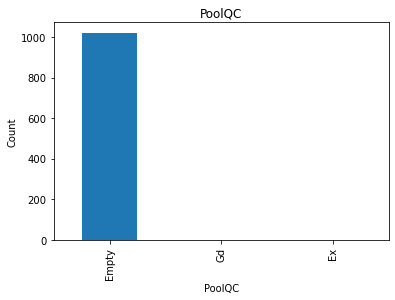

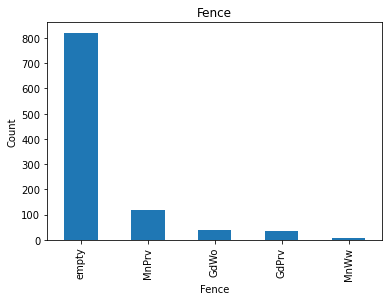

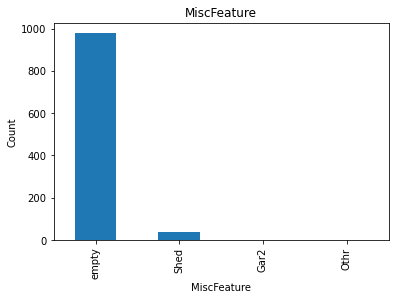

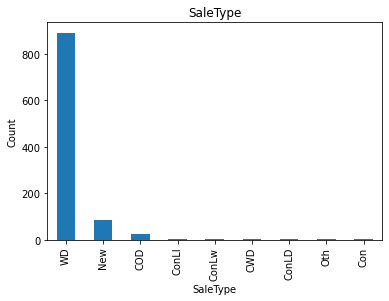

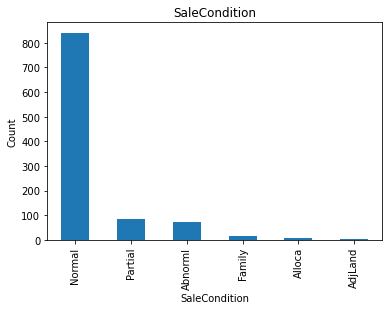

{'Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'PavedDrive',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities'}

In [29]:
objectcolumns(x_train,1)

In [30]:
x_train.isnull().sum().sort_values()

Id                 0
Fireplaces         0
Functional         0
KitchenQual        0
KitchenAbvGr       0
                ... 
RoofStyle          0
ExterCond          0
SaleCondition      0
MasVnrArea         6
LotFrontage      175
Length: 76, dtype: int64

In [35]:
x#for continuous Variables
x_train['LotFrontage'].fillna(x_train['LotFrontage'].mode().values[0],inplace=True)
x_train['MasVnrArea'].fillna(x_train['MasVnrArea'].mode().values[0],inplace=True)
x_train.isnull().sum().sort_values(ascending=False).head(20)


Id              0
FullBath        0
FireplaceQu     0
Fireplaces      0
Functional      0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
BsmtHalfBath    0
MSSubClass      0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
Electrical      0
CentralAir      0
HeatingQC       0
GarageType      0
GarageFinish    0
dtype: int64

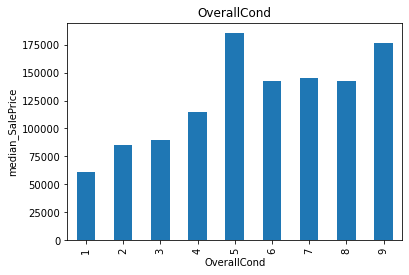

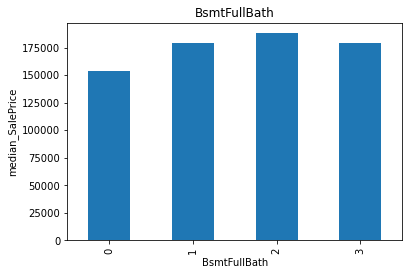

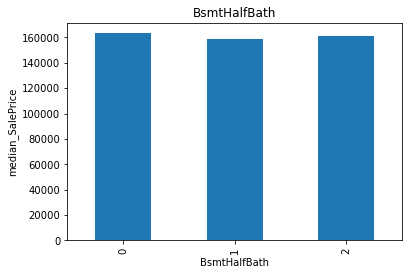

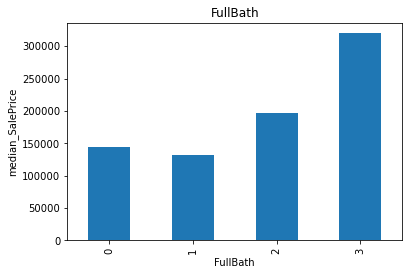

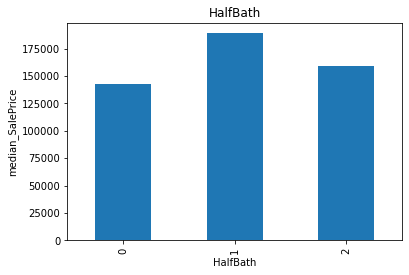

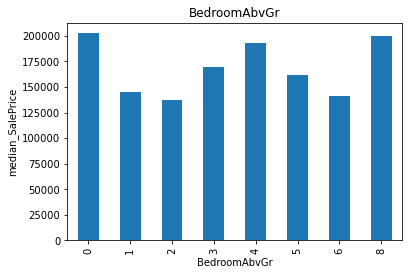

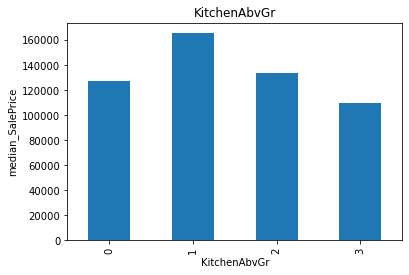

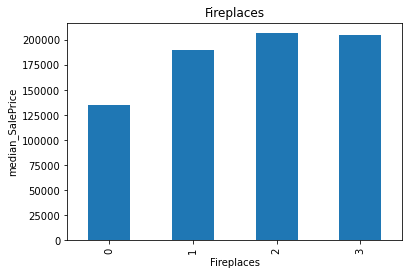

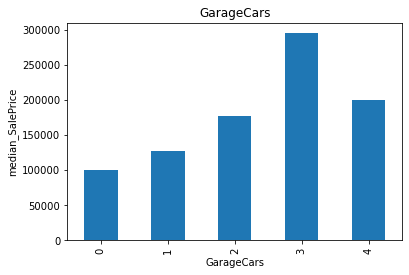

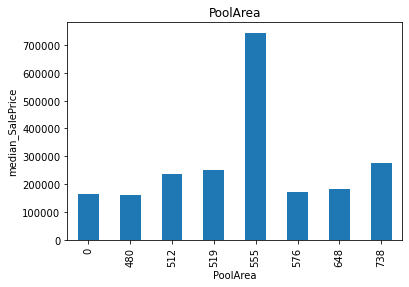

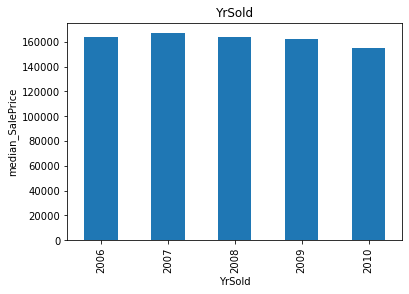

In [43]:
for i in x_train.columns:
    if x_train[i].dtype != 'O':
        if len(x_train[i].unique()) < 10:
            df.groupby(i)['SalePrice'].median().plot.bar()
            plt.title(i)
            plt.ylabel('median_SalePrice')
            plt.show()

0.0011003358025635874


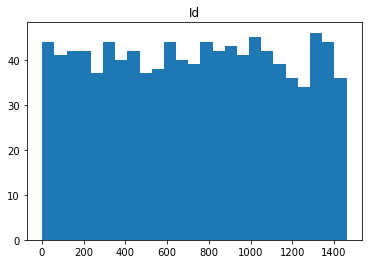

1.382174790218432


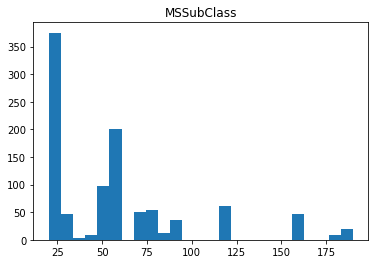

2.0496810812417485


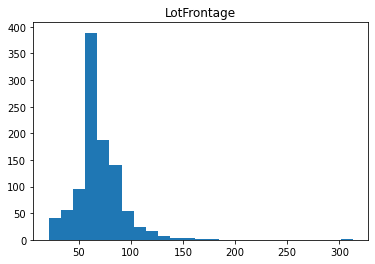

12.813679693783728


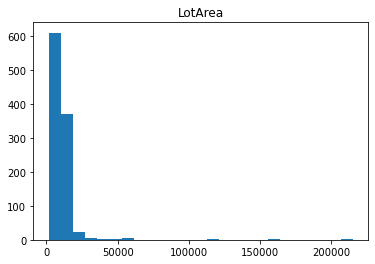

-0.5933359828787773


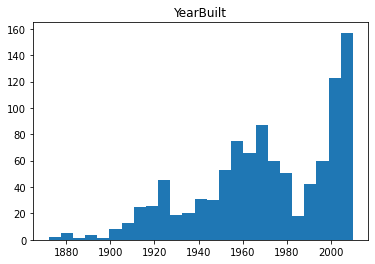

-0.46847677649897473


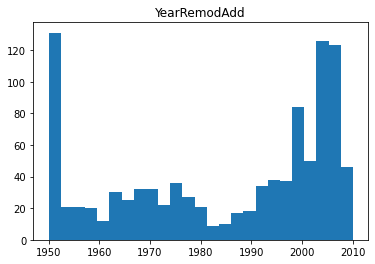

2.812244251143344


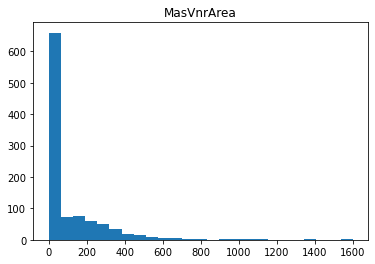

0.7874626394648363


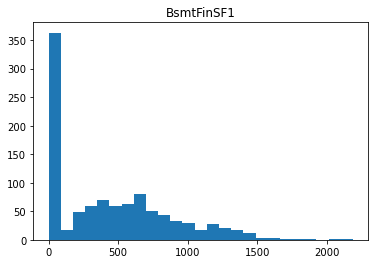

4.386359571656087


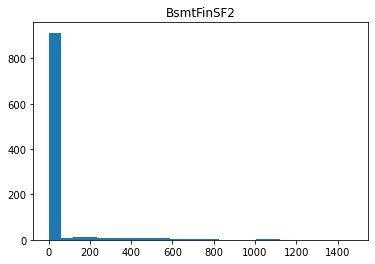

0.903706781786572


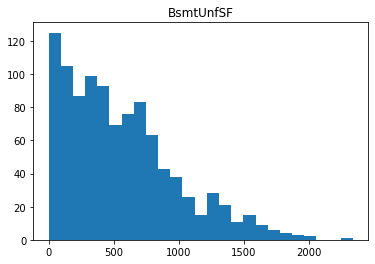

0.3437652485390187


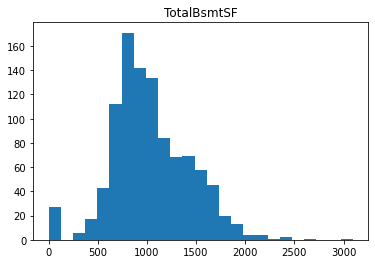

0.8201373434869467


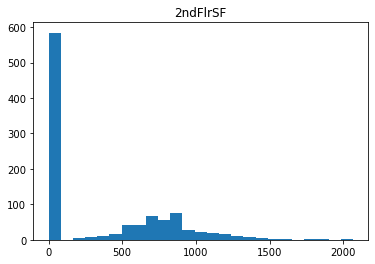

8.430508741417556


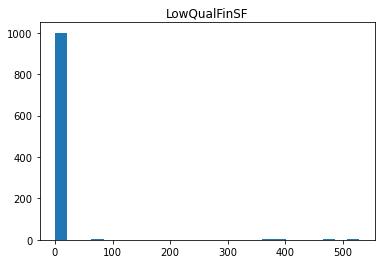

0.9400885820739466


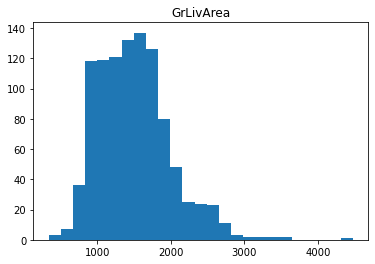

1.5948534812569768


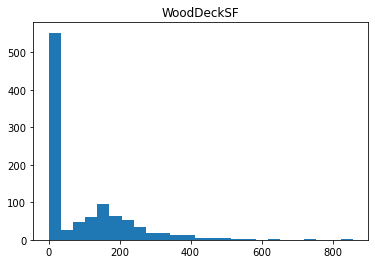

2.467283549737764


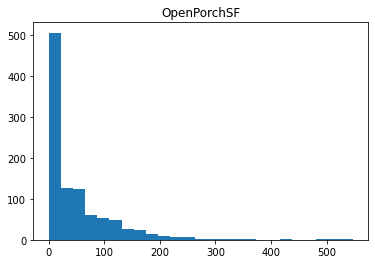

2.9694988290151643


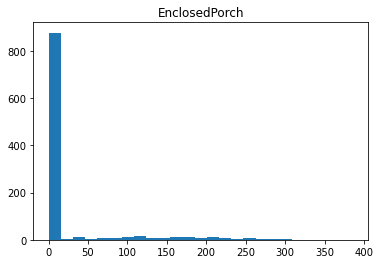

9.522352172445824


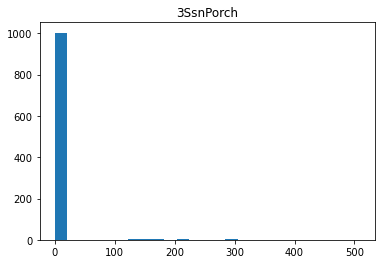

4.107006556656256


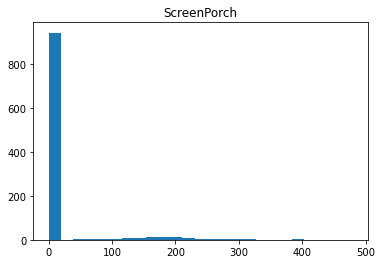

21.90538196176538


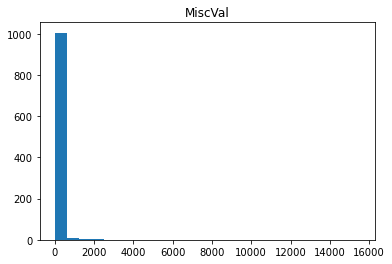

0.21270480760435082


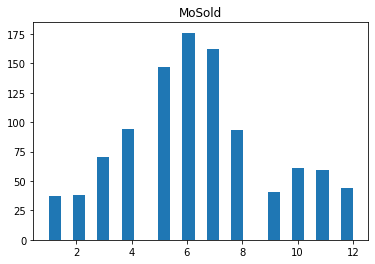

In [44]:
for i in x_train.columns:
    if x_train[i].dtype != 'O':
        if len(x_train[i].unique()) > 10:
            print(x_train[i].skew())
            plt.hist(x_train[i],bins=25)
            plt.title(i)
            plt.show()

<AxesSubplot:>

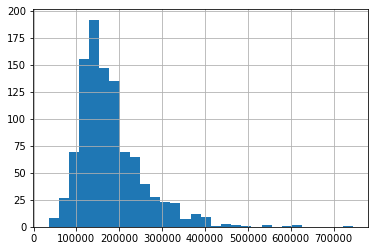

In [49]:
y_train.hist(bins=30)

In [66]:
x_train['Id']=df['Id']
x_train.sort_values('Id')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,854,0,1710,1,0,2,1,3,1,Gd,Typ,0,Empty,Attchd,RFn,2,TA,TA,Y,0,61,0,0,0,0,Empty,empty,empty,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,empty,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,0,0,1262,0,1,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,298,0,0,0,0,0,Empty,empty,empty,0,5,2007,WD,Normal
3,4,70,RL,60.0,9550,Pave,empty,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,756,0,1717,1,0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,3,TA,TA,Y,0,35,272,0,0,0,Empty,empty,empty,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,empty,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1053,0,2198,1,0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,3,TA,TA,Y,192,84,0,0,0,0,Empty,empty,empty,0,12,2008,WD,Normal
5,6,50,RL,85.0,14115,Pave,empty,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,566,0,1362,1,0,1,1,1,1,TA,Typ,0,Empty,Attchd,Unf,2,TA,TA,Y,40,30,0,320,0,0,Empty,MnPrv,Shed,700,10,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,694,0,1647,0,0,2,1,3,1,TA,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,40,0,0,0,0,Empty,empty,empty,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,0,0,2073,1,0,2,0,3,1,TA,Min1,2,TA,Attchd,Unf,2,TA,TA,Y,349,0,0,0,0,0,Empty,MnPrv,empty,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1152,0,2340,0,0,2,0,4,1,Gd,Typ,2,Gd,Attchd,RFn,1,TA,TA,Y,0,60,0,0,0,0,Empty,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,0,0,1078,1,0,1,0,2,1,Gd,Typ,0,Empty,Attchd,Unf,1,TA,TA,Y,366,0,112,0,0,0,Empty,empty,empty,0,4,2010,WD,Normal


In [76]:
x_train.index=x_train['Id']


In [ ]:
x_train.drop('Id',axis=1,inplace=True)


In [82]:
x_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105,50,RM,60.0,7758,Pave,empty,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,7,4,1931,1950,Gable,CompShg,Stucco,Stucco,BrkFace,600.0,TA,Fa,PConc,TA,TA,No,LwQ,224,Unf,0,816,1040,GasA,Ex,Y,FuseF,592,0,1818,0,0,1,1,4,1,TA,Typ,2,TA,Detchd,Unf,1,TA,TA,Y,0,0,0,0,184,0,Empty,empty,empty,0,6,2007,WD,Normal
1186,50,RL,60.0,9738,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,7,1924,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Gd,BrkTil,TA,TA,No,BLQ,392,Unf,0,392,784,GasA,Gd,Y,SBrkr,272,0,1221,1,0,1,0,4,1,TA,Typ,0,Empty,Attchd,Unf,1,TA,TA,Y,0,0,236,0,0,0,Empty,empty,empty,0,3,2006,WD,Normal
787,50,RM,60.0,10800,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,5,6,1915,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,PConc,Fa,TA,No,LwQ,686,Unf,0,0,686,GasA,TA,Y,SBrkr,686,0,1652,1,0,2,0,4,1,TA,Typ,0,Empty,Detchd,Unf,1,TA,TA,Y,0,0,196,0,0,0,Empty,empty,Shed,1200,6,2010,WD,Normal
380,60,RL,60.0,8123,Pave,empty,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,6,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,982,982,GasA,Ex,Y,SBrkr,793,0,1800,0,0,2,1,3,1,TA,Typ,1,TA,Attchd,Fin,2,TA,TA,Y,100,63,0,0,0,0,Empty,empty,empty,0,6,2009,WD,Normal
1130,90,RM,60.0,7200,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,SFoyer,5,5,1980,1980,Gable,CompShg,MetalSd,MetalSd,BrkFace,180.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,936,Unf,0,0,936,GasA,TA,Y,SBrkr,0,0,936,1,0,1,0,2,1,TA,Typ,0,Empty,Detchd,Unf,2,TA,TA,Y,49,0,0,0,0,0,Empty,empty,empty,0,8,2007,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,20,RL,85.0,10628,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1970,1970,Flat,Tar&Grv,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,Gd,Gd,GLQ,778,Unf,0,499,1277,GasA,TA,Y,SBrkr,0,0,1277,1,0,1,0,2,1,TA,Typ,1,Po,Attchd,Unf,2,TA,TA,Y,0,0,0,0,176,0,Empty,GdWo,empty,0,4,2007,WD,Normal
300,20,RL,80.0,14000,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,8,1950,2004,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,1092,1092,GasA,Ex,Y,SBrkr,0,0,1152,0,1,1,0,3,1,Gd,Typ,1,Gd,Attchd,Unf,1,TA,TA,Y,0,36,0,0,0,0,Empty,GdPrv,empty,0,8,2009,WD,Family
494,20,RL,70.0,7931,Pave,empty,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1960,1960,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,374,LwQ,532,363,1269,GasA,TA,Y,FuseA,0,0,1269,0,0,1,1,3,1,TA,Typ,1,Fa,Detchd,Unf,1,TA,TA,Y,0,0,0,0,0,0,Empty,empty,empty,0,6,2008,WD,Normal


In [83]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in x_train:
    if x_train[i].dtype == 'O':
        x_train[i] = le.fit_transform(x_train[i])


In [85]:
x_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105,50,4,60.0,7758,1,2,3,3,0,0,0,9,2,2,0,0,7,4,1931,1950,1,0,9,11,1,600.0,3,1,2,3,3,3,3,224,5,0,816,1040,1,0,1,1,592,0,1818,0,0,1,1,4,1,3,6,2,5,5,2,1,4,4,2,0,0,0,0,184,0,0,4,3,0,6,2007,8,4
1186,50,3,60.0,9738,1,2,3,3,0,4,0,7,2,2,0,0,5,7,1924,1950,1,0,0,0,2,0.0,3,2,0,3,3,3,1,392,5,0,392,784,1,2,1,3,272,0,1221,1,0,1,0,4,1,3,6,0,0,1,2,1,4,4,2,0,0,236,0,0,0,0,4,3,0,3,2006,8,4
787,50,4,60.0,10800,1,2,3,3,0,4,0,17,0,2,0,0,5,6,1915,1950,1,0,6,7,2,0.0,3,2,2,1,3,3,3,686,5,0,0,686,1,4,1,3,686,0,1652,1,0,2,0,4,1,3,6,0,0,5,2,1,4,4,2,0,0,196,0,0,0,0,4,2,1200,6,2010,8,4
380,60,3,60.0,8123,1,2,0,3,0,4,0,8,6,2,0,5,6,5,2000,2000,1,0,10,12,1,16.0,3,4,2,2,3,3,5,0,5,0,982,982,1,0,1,3,793,0,1800,0,0,2,1,3,1,3,6,1,5,1,0,2,4,4,2,100,63,0,0,0,0,0,4,3,0,6,2009,8,4
1130,90,4,60.0,7200,1,0,3,3,0,4,0,17,2,2,2,6,5,5,1980,1980,1,0,6,7,1,180.0,3,4,1,2,3,1,2,936,5,0,0,936,1,4,1,3,0,0,936,1,0,1,0,2,1,3,6,0,0,5,2,2,4,4,2,49,0,0,0,0,0,0,4,3,0,8,2007,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,20,3,85.0,10628,1,2,3,3,0,4,0,12,2,2,0,2,7,5,1970,1970,0,4,7,9,2,0.0,3,2,1,3,1,1,2,778,5,0,499,1277,1,4,1,3,0,0,1277,1,0,1,0,2,1,3,6,1,4,1,2,2,4,4,2,0,0,0,0,176,0,0,1,3,0,4,2007,8,4
300,20,3,80.0,14000,1,2,3,3,0,4,0,6,2,2,0,2,6,8,1950,2004,1,0,5,5,2,0.0,3,2,1,3,3,3,5,0,5,0,1092,1092,1,0,1,3,0,0,1152,0,1,1,0,3,1,2,6,1,3,1,2,1,4,4,2,0,36,0,0,0,0,0,0,3,0,8,2009,8,3
494,20,3,70.0,7931,1,2,3,3,0,4,0,12,2,2,0,2,5,6,1960,1960,1,0,3,13,2,0.0,3,4,1,3,3,3,1,374,3,532,363,1269,1,4,1,0,0,0,1269,0,0,1,1,3,1,3,6,1,2,5,2,1,4,4,2,0,0,0,0,0,0,0,4,3,0,6,2008,8,4


In [86]:
 model = XGBRegressor()

In [87]:
model.fit(x_train,y_train)

C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [88]:
Predictedvalue = model.predict(x_train)

In [90]:
from sklearn import metrics
score_1=metrics.r2_score(y_train,Predictedvalue)

# mean ABsolute Error

score_2 = metrics.mean_absolute_error(y_train,Predictedvalue)

print(score_1,score_2)

0.9998534884690549 660.9117997798435


In [92]:


x_train['log_MiscVal']= x_train['MiscVal'].replace(0,0.1)
x_train['log_MiscVal'] = np.log(x_train['log_MiscVal'])

x_train['log_LotArea']= x_train['LotArea'].replace(0,0.1)
x_train['log_LotArea'] = np.log(x_train['log_LotArea'])

x_train['log_LotFrontage']= x_train['LotFrontage'].replace(0,0.1)
x_train['log_LotFrontage'] = np.log(x_train['log_LotFrontage'])


x_train['log_MasVnrArea']= x_train['MasVnrArea'].replace(0,0.1)
x_train['log_MasVnrArea'] = np.log(x_train['log_MasVnrArea'])

x_train['log_OpenPorchSF']= x_train['OpenPorchSF'].replace(0,0.1)
x_train['log_OpenPorchSF'] = np.log(x_train['log_OpenPorchSF'])

x_train['log_WoodDeckSF']= x_train['WoodDeckSF'].replace(0,0.1)
x_train['log_WoodDeckSF'] = np.log(x_train['log_WoodDeckSF'])





In [93]:
x_train.drop(['MiscVal','LotArea','LotFrontage','MasVnrArea','OpenPorchSF','WoodDeckSF'],axis=1,inplace=True)

In [94]:
model.fit(x_train,y_train)

C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [95]:
Predictedvalue = model.predict(x_train)

In [96]:
from sklearn import metrics
score_1=metrics.r2_score(y_train,Predictedvalue)

# mean ABsolute Error

score_2 = metrics.mean_absolute_error(y_train,Predictedvalue)

print(score_1,score_2)

0.9998534884690549 660.9117997798435


In [97]:
x_train

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,log_MiscVal,log_LotArea,log_LotFrontage,log_MasVnrArea,log_OpenPorchSF,log_WoodDeckSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105,50,4,1,2,3,3,0,0,0,9,2,2,0,0,7,4,1931,1950,1,0,9,11,1,3,1,2,3,3,3,3,224,5,0,816,1040,1,0,1,1,592,0,1818,0,0,1,1,4,1,3,6,2,5,5,2,1,4,4,2,0,0,184,0,0,4,3,6,2007,8,4,-2.302585,8.956480,4.094345,6.396930,-2.302585,-2.302585
1186,50,3,1,2,3,3,0,4,0,7,2,2,0,0,5,7,1924,1950,1,0,0,0,2,3,2,0,3,3,3,1,392,5,0,392,784,1,2,1,3,272,0,1221,1,0,1,0,4,1,3,6,0,0,1,2,1,4,4,2,236,0,0,0,0,4,3,3,2006,8,4,-2.302585,9.183791,4.094345,-2.302585,-2.302585,-2.302585
787,50,4,1,2,3,3,0,4,0,17,0,2,0,0,5,6,1915,1950,1,0,6,7,2,3,2,2,1,3,3,3,686,5,0,0,686,1,4,1,3,686,0,1652,1,0,2,0,4,1,3,6,0,0,5,2,1,4,4,2,196,0,0,0,0,4,2,6,2010,8,4,7.090077,9.287301,4.094345,-2.302585,-2.302585,-2.302585
380,60,3,1,2,0,3,0,4,0,8,6,2,0,5,6,5,2000,2000,1,0,10,12,1,3,4,2,2,3,3,5,0,5,0,982,982,1,0,1,3,793,0,1800,0,0,2,1,3,1,3,6,1,5,1,0,2,4,4,2,0,0,0,0,0,4,3,6,2009,8,4,-2.302585,9.002455,4.094345,2.772589,4.143135,4.605170
1130,90,4,1,0,3,3,0,4,0,17,2,2,2,6,5,5,1980,1980,1,0,6,7,1,3,4,1,2,3,1,2,936,5,0,0,936,1,4,1,3,0,0,936,1,0,1,0,2,1,3,6,0,0,5,2,2,4,4,2,0,0,0,0,0,4,3,8,2007,8,4,-2.302585,8.881836,4.094345,5.192957,-2.302585,3.891820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,20,3,1,2,3,3,0,4,0,12,2,2,0,2,7,5,1970,1970,0,4,7,9,2,3,2,1,3,1,1,2,778,5,0,499,1277,1,4,1,3,0,0,1277,1,0,1,0,2,1,3,6,1,4,1,2,2,4,4,2,0,0,176,0,0,1,3,4,2007,8,4,-2.302585,9.271247,4.442651,-2.302585,-2.302585,-2.302585
300,20,3,1,2,3,3,0,4,0,6,2,2,0,2,6,8,1950,2004,1,0,5,5,2,3,2,1,3,3,3,5,0,5,0,1092,1092,1,0,1,3,0,0,1152,0,1,1,0,3,1,2,6,1,3,1,2,1,4,4,2,0,0,0,0,0,0,3,8,2009,8,3,-2.302585,9.546813,4.382027,-2.302585,3.583519,-2.302585
494,20,3,1,2,3,3,0,4,0,12,2,2,0,2,5,6,1960,1960,1,0,3,13,2,3,4,1,3,3,3,1,374,3,532,363,1269,1,4,1,0,0,0,1269,0,0,1,1,3,1,3,6,1,2,5,2,1,4,4,2,0,0,0,0,0,4,3,6,2008,8,4,-2.302585,8.978534,4.248495,-2.302585,-2.302585,-2.302585


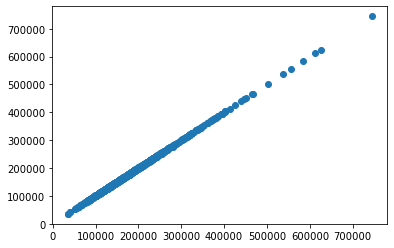

In [99]:
plt.scatter(y_train,Predictedvalue)

In [ ]:
x_test.index=x_test['Id']
x_test.drop('Id',axis=1,inplace=True)

In [104]:
x_test['MiscFeature'].fillna('empty',inplace=True)   # Miscellaneous feature are not Present

x_test['GarageType'].fillna('empty',inplace=True)   # Since the count of Emmpty values are same Cant be Coincidence
x_test['GarageCond'].fillna('empty',inplace=True)
x_test['GarageQual'].fillna('empty',inplace=True)
x_test['GarageFinish'].fillna('empty',inplace=True)

x_test['Fence'].fillna('empty',inplace=True)     # assuming NO Fence 
x_test['MiscFeature'].fillna('empty',inplace=True)   # Miscellaneous feature are not Present

x_test['BsmtCond'].fillna('empty',inplace=True)   # Since the count of Emmpty values are equal
x_test['BsmtExposure'].fillna('empty',inplace=True)   
x_test['BsmtFinType1'].fillna('empty',inplace=True)   
x_test['BsmtFinType2'].fillna('empty',inplace=True)   
x_test['BsmtQual'].fillna('empty',inplace=True)  

x_test['FireplaceQu'] = np.where(((pd.isnull(x_test['FireplaceQu'])) & (x_test['Fireplaces']==0)),'Empty',x_test['FireplaceQu'])    #  replacing Empty Where Fire Places equal t0 0 

x_test['MasVnrType'].fillna('empty',inplace=True)      # replacing with Empty Value

x_test['Electrical'].fillna(x_test['Electrical'].mode().values[0],inplace=True)     # filling with Mode Value since the House Cannot be with the Electrical System so assigning the Common type of Electrical System


x_test['PoolQC'] = np.where(((pd.isnull(x_test['PoolQC'])) & (x_test['PoolArea']==0)),'Empty',x_test['PoolQC'])  #  if the Pool Area is Zero then pool Quality will be empty


x_test['Alley'].fillna('empty',inplace=True)      # replacing with Empty Value since the % of missing Vlaues is High assuming it cannot be mistake so creating seperate Category



In [106]:
x_test.isnull().sum().sort_values(ascending=False).head(20)

LotFrontage     84
MasVnrArea       2
MSSubClass       0
HalfBath         0
FireplaceQu      0
Fireplaces       0
Functional       0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
FullBath         0
GarageFinish     0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
Electrical       0
GarageType       0
GarageCars       0
dtype: int64

In [107]:
x#for continuous Variables
x_test['LotFrontage'].fillna(x_test['LotFrontage'].mode().values[0],inplace=True)
x_test['MasVnrArea'].fillna(x_test['MasVnrArea'].mode().values[0],inplace=True)
x_test.isnull().sum().sort_values(ascending=False).head(20)


MSSubClass      0
GarageFinish    0
FireplaceQu     0
Fireplaces      0
Functional      0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
Electrical      0
CentralAir      0
GarageType      0
GarageCars      0
Heating         0
dtype: int64

In [109]:

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in x_test:
    if x_test[i].dtype == 'O':
        x_test[i] = le.fit_transform(x_test[i])



In [111]:
predicted_test = model.predict(x_test)

In [112]:
from sklearn import metrics
score_1=metrics.r2_score(y_test,predicted_test)

# mean ABsolute Error

score_2 = metrics.mean_absolute_error(y_test,predicted_test)

print(score_1,score_2)

-1.4211640406982848 99881.72687464327


In [115]:


x_test['log_MiscVal']= x_test['MiscVal'].replace(0,0.1)
x_test['log_MiscVal'] = np.log(x_test['log_MiscVal'])

x_test['log_LotArea']= x_test['LotArea'].replace(0,0.1)
x_test['log_LotArea'] = np.log(x_test['log_LotArea'])

x_test['log_LotFrontage']= x_test['LotFrontage'].replace(0,0.1)
x_test['log_LotFrontage'] = np.log(x_test['log_LotFrontage'])


x_test['log_MasVnrArea']= x_test['MasVnrArea'].replace(0,0.1)
x_test['log_MasVnrArea'] = np.log(x_test['log_MasVnrArea'])

x_test['log_OpenPorchSF']= x_test['OpenPorchSF'].replace(0,0.1)
x_test['log_OpenPorchSF'] = np.log(x_test['log_OpenPorchSF'])

x_test['log_WoodDeckSF']= x_test['WoodDeckSF'].replace(0,0.1)
x_test['log_WoodDeckSF'] = np.log(x_test['log_WoodDeckSF'])



In [116]:
x_test.drop(['MiscVal','LotArea','LotFrontage','MasVnrArea','OpenPorchSF','WoodDeckSF'],axis=1,inplace=True)

In [117]:
predicted_test = model.predict(x_test)

In [118]:
from sklearn import metrics
score_1=metrics.r2_score(y_test,predicted_test)

# mean ABsolute Error

score_2 = metrics.mean_absolute_error(y_test,predicted_test)

print(score_1,score_2)

0.7182138766180658 21450.945910031394


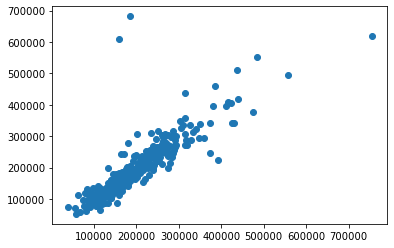

In [119]:
plt.scatter(y_test,predicted_test)